In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

fl=pd.read_csv(r"Feature_list.csv")
ds1 = pd.read_csv(r"Dataset1A.csv").sample(5000)
ds2 = pd.read_csv(r"Dataset1B.csv").sample(5000)
ds3 = pd.read_csv(r"Dataset2A.csv").sample(5000)
ds4 = pd.read_csv(r"Dataset2B.csv").sample(5000)
ds5 = pd.read_csv(r"Dataset2C.csv").sample(5000)
ds1["label"]="1A"
ds2["label"]="1B"
ds3["label"]="2A"
ds4["label"]="2B"
ds5["label"]="2C"
#ds_group=[ds1,ds2,ds3,ds4,ds5]

table1=pd.concat([ds1,ds2])
table2=pd.concat([ds3,ds4,ds5])
table3=pd.concat([ds1,ds2,ds3,ds4,ds5])
table4=pd.concat([ds2,ds5])

# Functions

In [2]:
def remove_outliers(table):
    for col_name in table.columns:
        q1=table[col_name].quantile(0.25)
        q3=table[col_name].quantile(0.75)
        
        #table[col_name][(table[col_name]<q1)]=table[col_name].mean()
        #table[col_name][(table[col_name]>q3)]=table[col_name].mean()
        
        d1 = table[col_name][(table[col_name]<q1)].index
        d2 = table[col_name][(table[col_name]>q3)].index
        
        table[col_name].drop(d1)
        table[col_name].drop(d2)
        
    return table

In [3]:
rlabels=ds1.columns
rlabels = rlabels.drop(['Participant', 'SleepStage', 'Video_Posogram', 'Video_Clusterogram',"label"]).copy()

In [27]:
def plot(i, Label="None", clarr = [0,1,2,3], clsort="SleepStage"):
    import gc
    
    gc.collect()
    i = i[i["SleepStage"]!='A'].copy()
    le=LabelEncoder();le2=LabelEncoder();
    cdict = {0: 'red', 1: 'blue', 2: 'green',3:"aqua",4:"yellow"}
    temp=i.drop(['Participant', 'SleepStage', 'Video_Posogram', 'Video_Clusterogram',"label"],axis=1).copy()

    #temp = temp_o.sample(n=53,axis='columns').copy()
    #emp=remove_outliers(temp[temp.columns[0:54]])
    #emp =(temp-temp.mean())/temp.std()

    target=le2.fit_transform(i[clsort])
    #target=le2.fit_transform(i["label"])
    
    #mapping = dict(zip(le2.inverse_transform([0,1,2,3,4]),le2.transform(i["SleepStage"].unique())))
    #print(le2.inverse_transform(clarr),le2.transform(i["SleepStage"].unique()))
    
    labn = (le2.inverse_transform(clarr))

    pca=PCA()
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
    components = pipe.fit_transform(temp)

    #sns.jointplot(x=components[:,1], y=components[:,2], hue=target, kind="kde")
    top_features = []# [np.argsort(pca.components_[1])[::-1][:1]]
    for qtfr in range(1,11):
        top_features.append(np.argsort(pca.components_[qtfr])[::-1][0])
    
    top_top_features = np.argsort(pca.components_[1])[::-1][:10]
    print(f" Top TOP Features {rlabels[top_top_features]}")
    print("\n\n\n")
    
    eigens=pca.explained_variance_ratio_
    top_eigens = np.argsort(eigens)[::-1][:10]
    #print(f"Variance Explained by top 3 Principal Components {eigens[top_eigens]}")
    
    #print(eigens[top_eigens].shape)
    #print(rlabels[top_features].shape)
    #print(top_features)
    #top_features = top_features.reshape(-1)
    #print(top_eigens)
    
    print(np.vstack([eigens[top_eigens],rlabels[top_features]] ))
    
    fig, ax = plt.subplots()
    vals=[bla for bla in range(0,10)]
    bars = plt.barh(y=rlabels[top_features],width=eigens[:10])
    ax.bar_label(bars,fmt="%03.2f")
    plt.title("Principal Components for Dataset "+Label)# + " ["+str((temp.shape)[1])+" Features Used]")
    plt.ylabel("Highest Contributing Feature")
    plt.xlabel("Variance Explained")
    plt.show()
    
    
    fig, ax = plt.subplots()
    vals=[bla for bla in range(0,10)]
    bars = plt.barh(y=rlabels[top_top_features],width=pca.components_[1][top_top_features])
    ax.bar_label(bars,fmt="%03.2f")
    plt.title("Features in First Principal Components for Dataset "+Label)# + " ["+str((temp.shape)[1])+" Features Used]")
    plt.ylabel("Top Features in First PC")
    plt.xlabel("Feature Weight")
    plt.show()
    
    #print(dict(zip(eigens[top_eigens],rlabels[top_top_features])))
    
    print("\n\n\n")
    
    print(i["SleepStage"].value_counts())
    
    import gc
    gc.collect()    
    
    fig, ax = plt.subplots()
    for g in np.unique(target):
        ix = np.where(target == g)
        comp1=components[:, 0]
        comp2=components[:, 1]
        plt.scatter(comp1[ix], comp2[ix], 0.2,cdict[g])
        plt.title("PCA on Dataset "+Label)# + " ["+str((temp.shape)[1])+" Features Used]")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend(labn, prop={'size': 10})

    #plt.axis('equal');
    plt.axis([-10,10,-10,10])

    plt.show()
    
    
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for g in np.unique(target):
        ix = np.where(target == g)
        comp1=components[:, 0]
        comp2=components[:, 1]
        comp3=components[:, 2]
        plt.scatter(comp1[ix], comp2[ix], comp3[ix])
        #plt.scatter(comp1[ix], comp2[ix], 0.2,cdict[g])
        plt.title("Dataset "+Label + " ["+str((temp.shape)[1])+" Features Used]")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        ax.set_zlabel("Principal Component 3")
        plt.legend(labn, prop={'size': 10})

    #plt.axis('equal');
    plt.axis([-10,10,-10,10])

    plt.show()


# Datasets

 Top TOP Features Index(['Resp_sHF', 'Resp_SDNN', 'Resp_sLF', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'LF/HF', 'Resp_meanBBi'],
      dtype='object')




[[0.28351832839661045 0.13359934130895995 0.08366684608607358
  0.08018245306310902 0.07061398982265765 0.047317139483930876
  0.03956955333700059 0.036869731844001406 0.028860511815501647
  0.02466810271338142]
 ['Resp_sHF' 'Sigma' 'LEMGR_SD' 'JEMG_RMS' 'LEMGR_MAV' 'HR_est'
  'Resp_meanBBi' 'RRI_est' 'Tot_Pow' 'Video_Movement']]


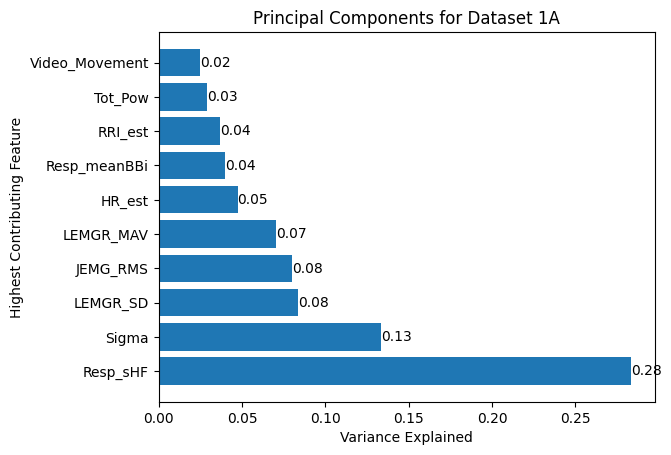

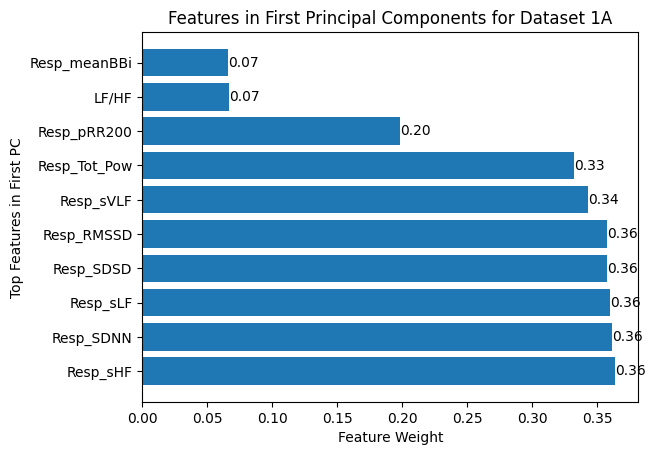





N2    2330
N3    1165
R      746
N1     665
Name: SleepStage, dtype: int64


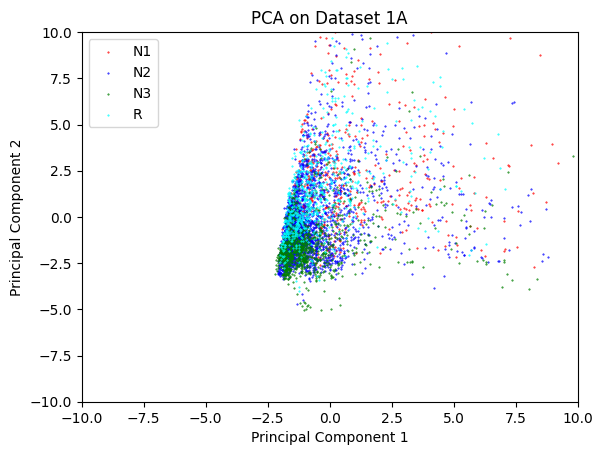

ValueError: need at least one array to concatenate

<Figure size 640x480 with 1 Axes>

In [28]:
plot(ds1, "1A")

 Top TOP Features Index(['Resp_sHF', 'Resp_sLF', 'Resp_SDNN', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'Resp_meanBBi', 'LEMGR_SD'],
      dtype='object')




[[0.28034026207622076 0.13996408264862623 0.10277999609219447
  0.09188426360524532 0.059849226650266915 0.040107033836460144
  0.031980066034732565 0.0316323238480466 0.02651908700162793
  0.021072984548149817]
 ['Resp_sHF' 'LEMGL_MAV' 'Sigma' 'JEMG_RMS' 'HR_est' 'Resp_BR' 'Band 2'
  'LEMGR_WL' 'Quad1_Dist' 'Video_Movement']]


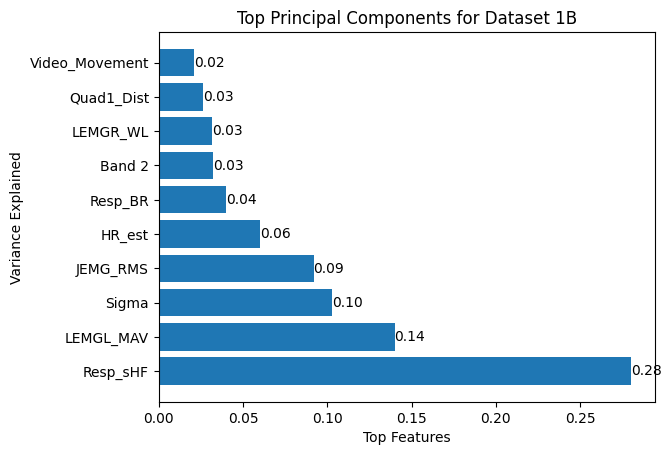

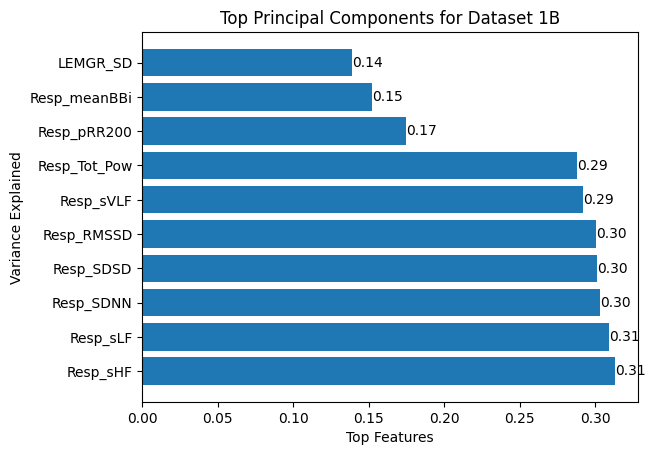





N2    2391
N1    1049
N3     838
R      713
Name: SleepStage, dtype: int64


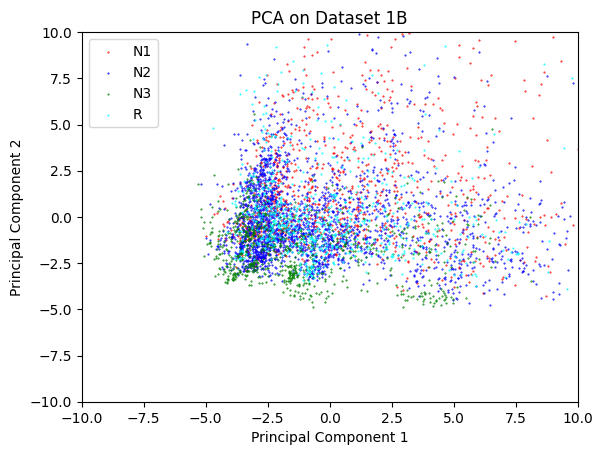

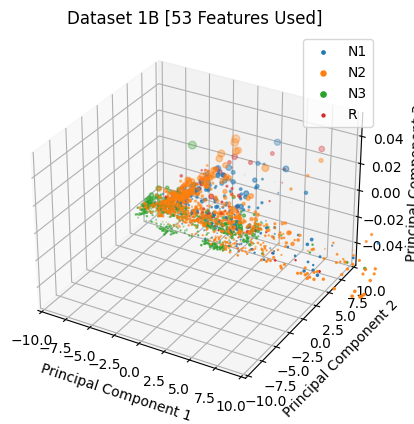

In [6]:
plot(ds2, "1B")

 Top TOP Features Index(['Resp_sHF', 'Resp_SDNN', 'Resp_sLF', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'F-Sigma', 'Resp_meanBBi'],
      dtype='object')




[[0.27564727651335447 0.138580065827951 0.10866536045819343
  0.08589013773408123 0.06606220521951138 0.04506611445304586
  0.03587534305461966 0.031560157703679814 0.029427124980197637
  0.022868753601502426]
 ['Resp_sHF' 'Sigma' 'Sigma' 'JEMG_RMS' 'HR_est' 'Resp_meanBBi' 'Resp_BR'
  'LEMGR_MAV' 'LF/HF' 'Video_Movement']]


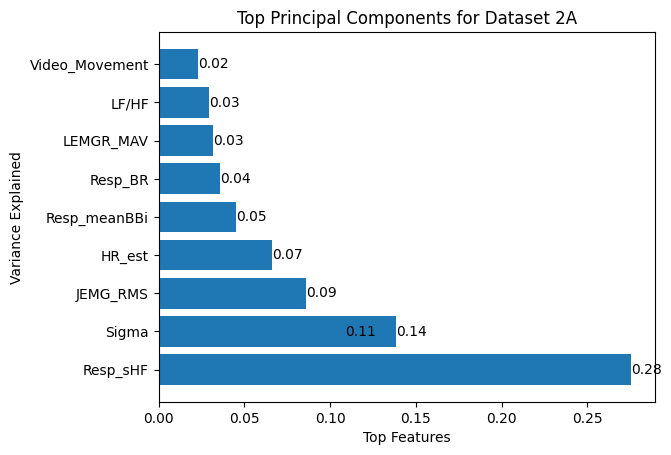

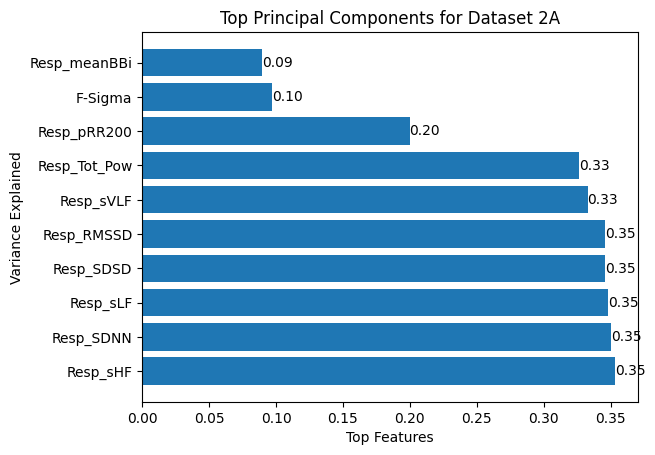





N2    2303
N3    1041
N1     897
R      752
Name: SleepStage, dtype: int64


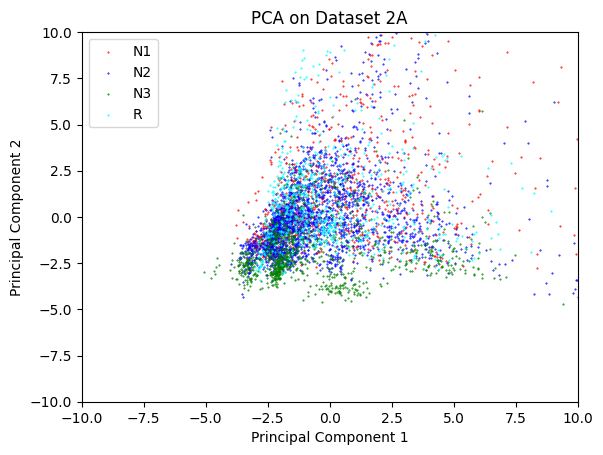

ValueError: need at least one array to concatenate

<Figure size 640x480 with 1 Axes>

In [7]:
plot(ds3, "2A")

 Top TOP Features Index(['Resp_sHF', 'Resp_sLF', 'Resp_SDNN', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'LEMGL_MAV', 'LEMGL_RMS', 'LEMGL_SD'],
      dtype='object')




[[0.27856024041440647 0.15136558585452006 0.11291034782779057
  0.09558203360703452 0.058716969615528386 0.048326972053434836
  0.033048432158096525 0.03180555044457325 0.020040829564532563
  0.019657541693482793]
 ['Resp_sHF' 'LEMGR_RMS' 'Sigma' 'JEMG_MAV' 'HR_est' 'Resp_BR' 'Band 1'
  'E4_activity' 'Video_Movement' 'S-Sigma']]


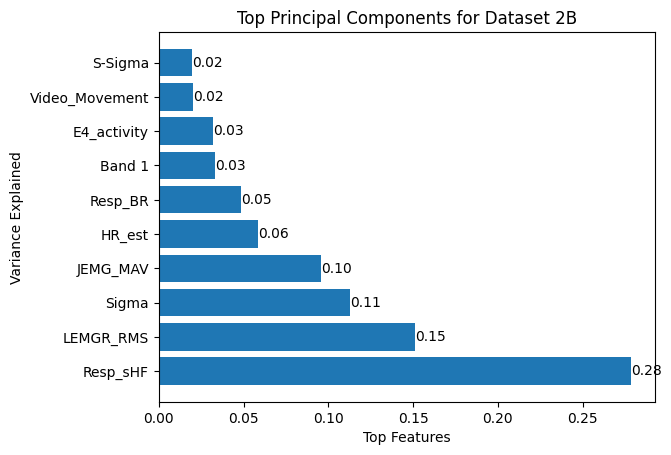

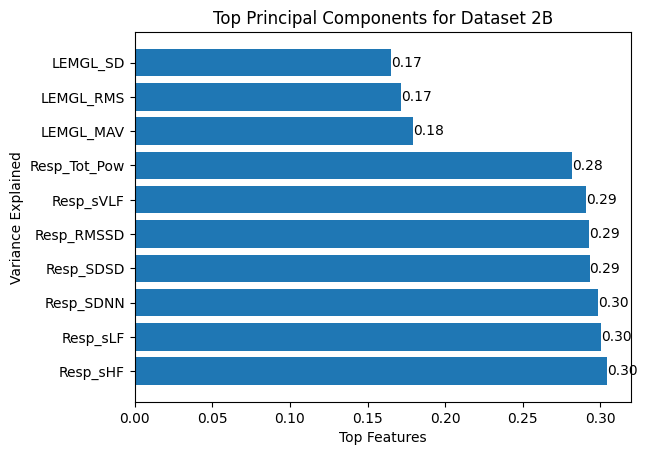





N2    2371
N1    1129
N3     841
R      651
Name: SleepStage, dtype: int64


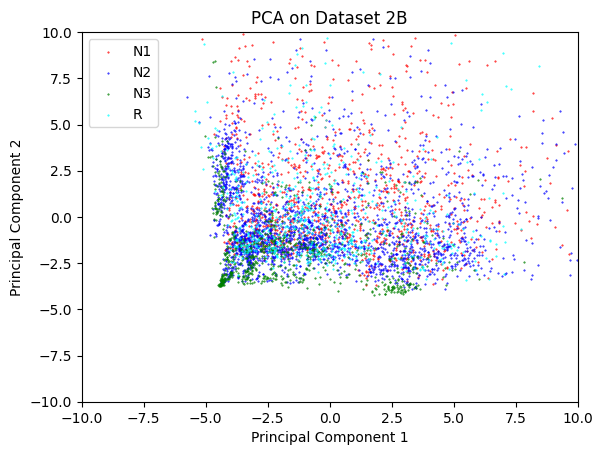

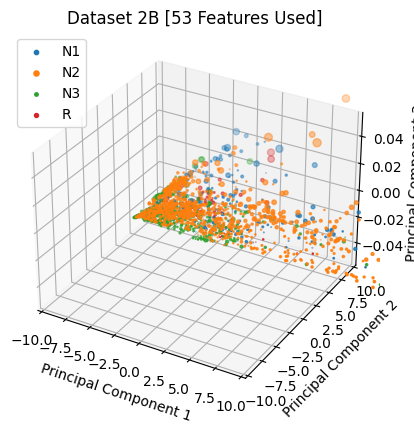

In [8]:
plot(ds4, "2B")

 Top TOP Features Index(['Resp_sHF', 'Resp_sLF', 'Resp_SDNN', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'JEMG_SD', 'JEMG_RMS'],
      dtype='object')




[[0.2686759941209862 0.13779161623373332 0.0882928355837427
  0.08103442820937606 0.06763273442969489 0.052002977604012006
  0.038108201466419564 0.03489731482607684 0.03193510255633223
  0.02776617935132476]
 ['Resp_sHF' 'Band 4' 'LEMGR_RMS' 'LEMGR_RMS' 'LEMGL_RMS' 'HR_est'
  'Resp_BR' 'F-Sigma' 'LF/HF' 'Video_Movement']]


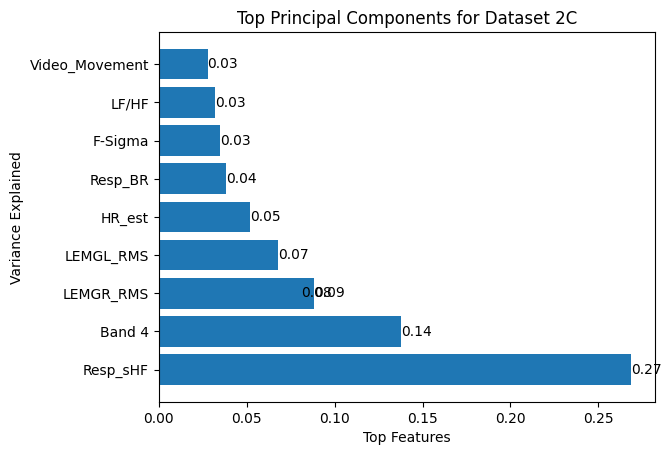

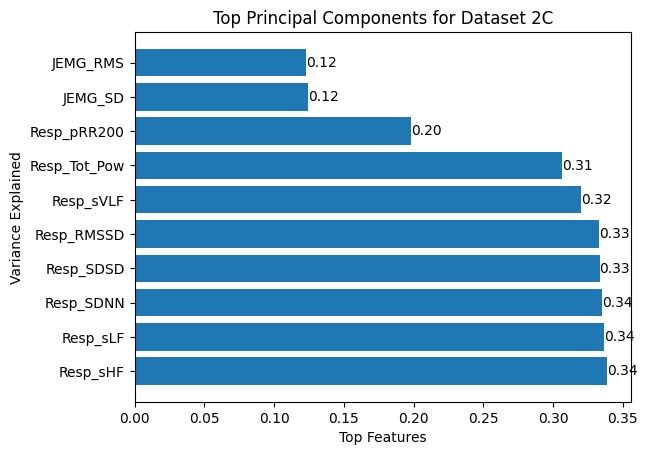





N2    2466
N3    1040
N1     741
R      730
Name: SleepStage, dtype: int64


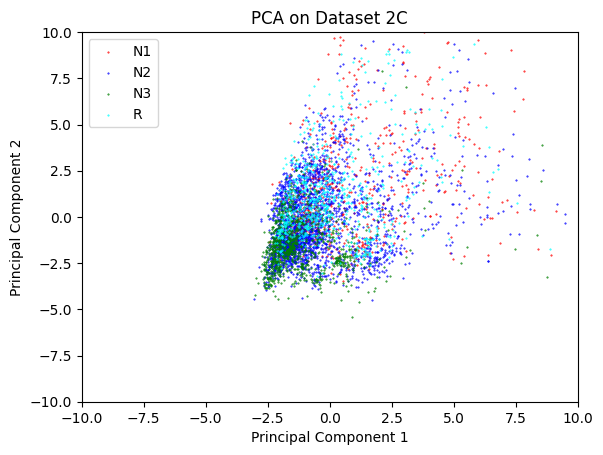

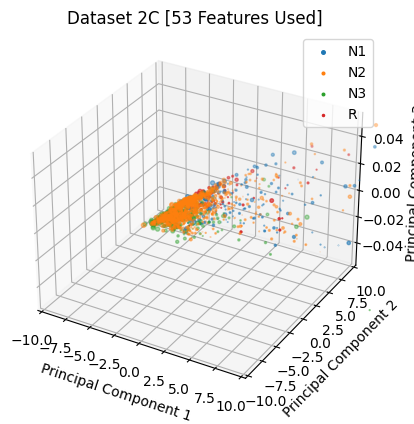

In [9]:
plot(ds5, "2C")

 Top TOP Features Index(['Resp_sHF', 'Resp_sLF', 'Resp_SDNN', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'JEMG_RMS', 'Resp_meanBBi'],
      dtype='object')




[[0.26908318800575254 0.1320502817516476 0.08905916162205077
  0.08495404925635974 0.06481827748624917 0.04191120461264265
  0.03842529656984951 0.03553488030374718 0.032216479281712895
  0.029688416187801665]
 ['Resp_sHF' 'LEMGR_RMS' 'LEMGL_RMS' 'LEMGL_RMS' 'LEMGR_MAV' 'RRI_est'
  'Tot_Pow' 'Resp_meanBBi' 'Band 1' 'Video_Movement']]


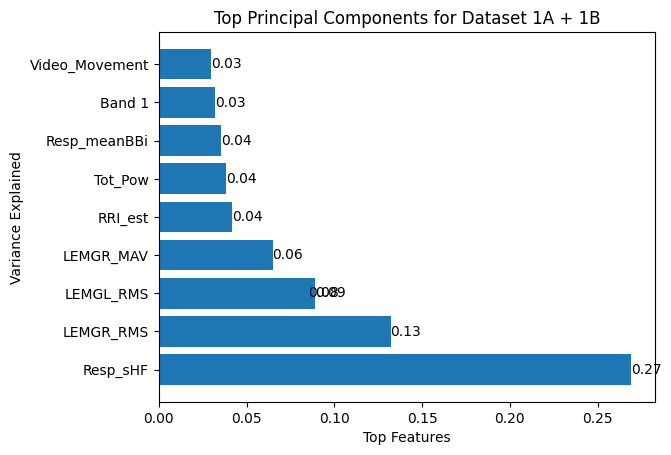

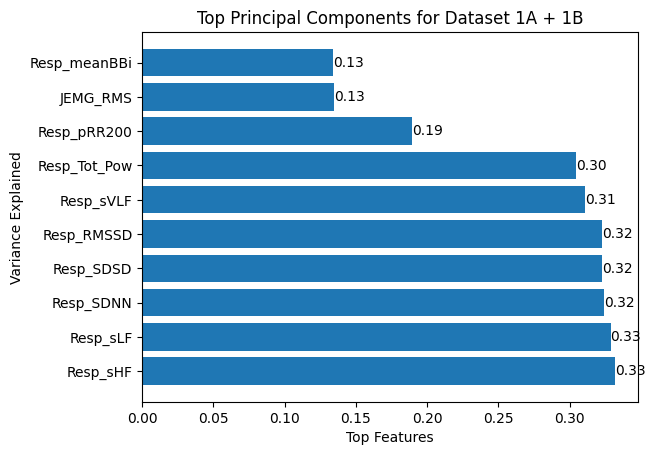





N2    4857
N3    1878
N1    1790
R     1443
Name: SleepStage, dtype: int64


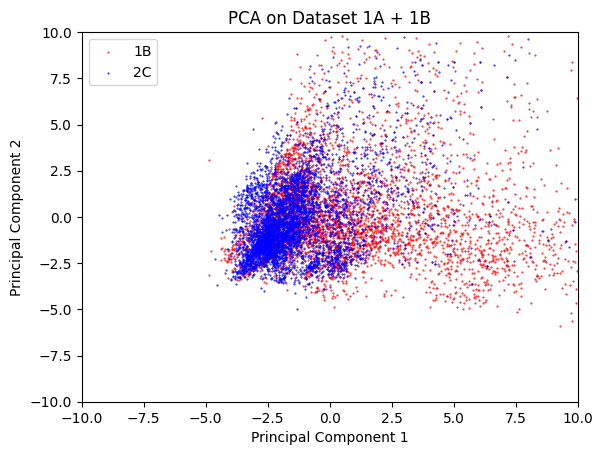

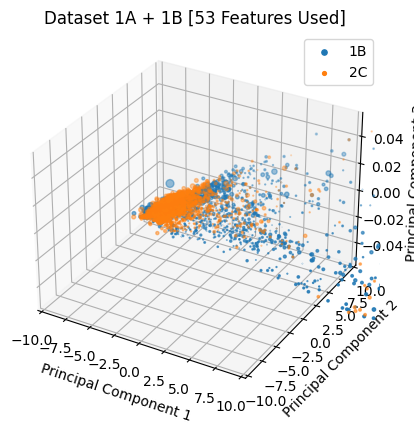

 Top TOP Features Index(['Resp_sHF', 'Resp_sLF', 'Resp_SDNN', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'JEMG_RMS', 'Resp_meanBBi'],
      dtype='object')




[[0.26908318800575254 0.1320502817516476 0.08905916162205077
  0.08495404925635974 0.06481827748624917 0.04191120461264265
  0.03842529656984951 0.03553488030374718 0.032216479281712895
  0.029688416187801665]
 ['Resp_sHF' 'LEMGR_RMS' 'LEMGL_RMS' 'LEMGL_RMS' 'LEMGR_MAV' 'RRI_est'
  'Tot_Pow' 'Resp_meanBBi' 'Band 1' 'Video_Movement']]


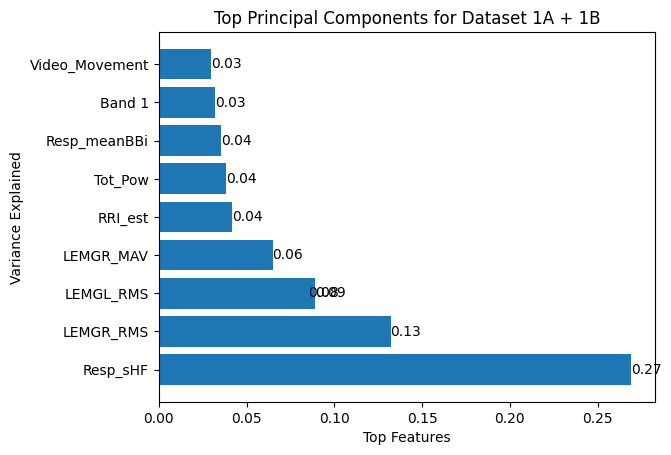

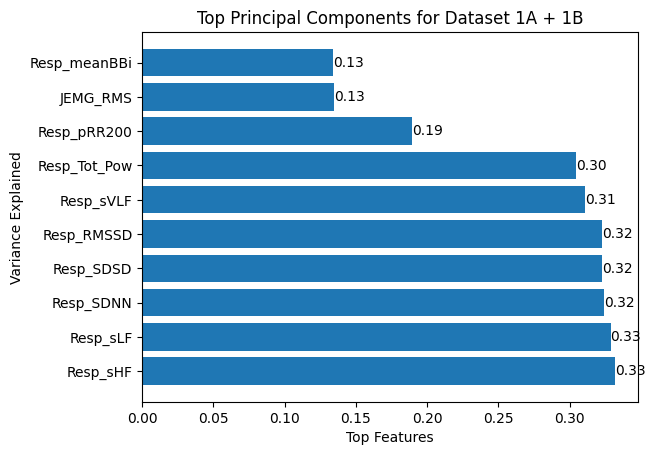





N2    4857
N3    1878
N1    1790
R     1443
Name: SleepStage, dtype: int64


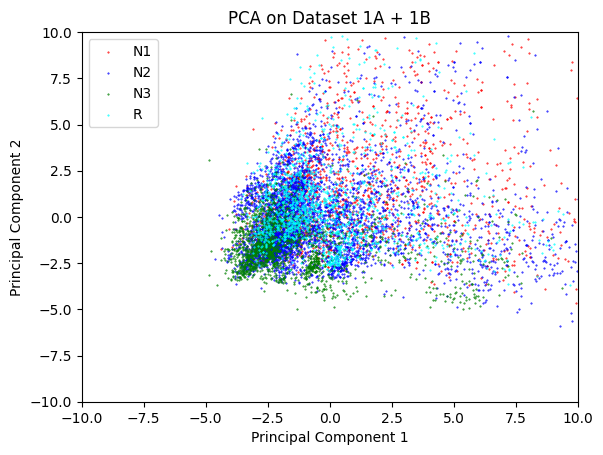

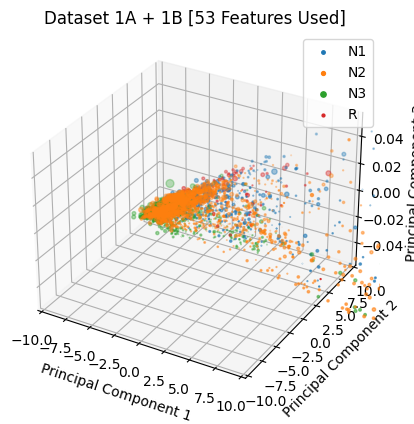

In [10]:
table1=pd.concat([ds2,ds5])

plot(table1, "1A + 1B", clarr=[0,1],clsort="label")
plot(table1, "1A + 1B", clarr=[0,1,2,3])

 Top TOP Features Index(['Resp_sHF', 'Resp_sLF', 'Resp_SDNN', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'Resp_meanBBi', 'JEMG_RMS'],
      dtype='object')




[[0.26901951210046954 0.13292439104603254 0.08917329298541331
  0.08528374405922613 0.06481428468931082 0.042224364735174526
  0.0382502876307617 0.03672627878816999 0.03131361367051093
  0.028419460324888374]
 ['Resp_sHF' 'LEMGR_SD' 'Sigma' 'JEMG_RMS' 'HR_est' 'RRI_est' 'Tot_Pow'
  'Resp_BR' 'Band 1' 'Video_Movement']]


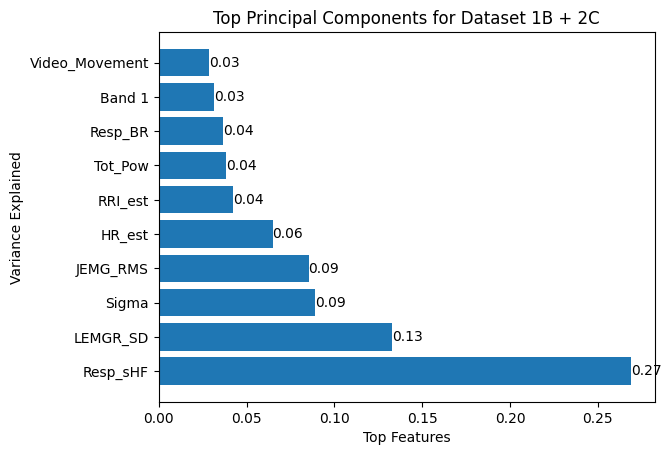

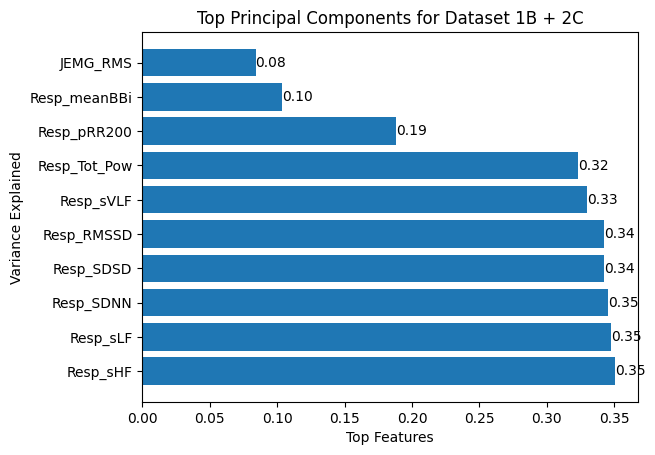





N2    4721
N3    2003
N1    1714
R     1459
Name: SleepStage, dtype: int64


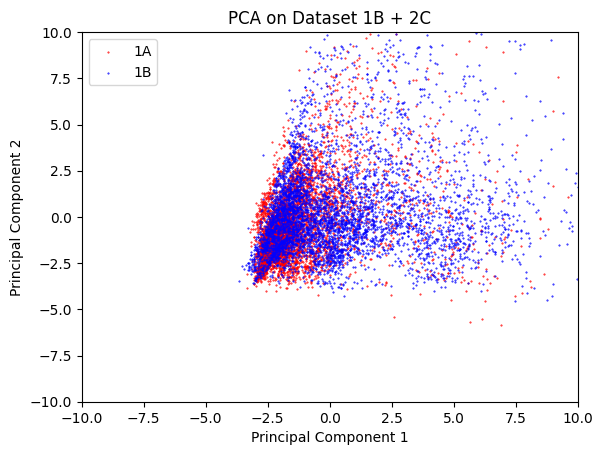

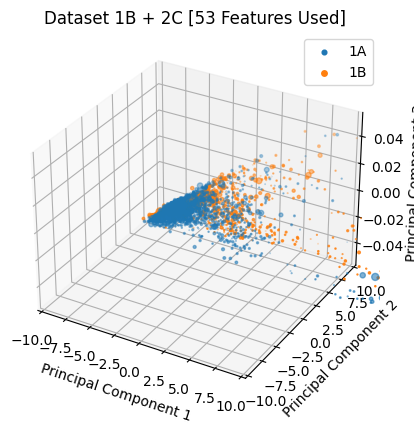

 Top TOP Features Index(['Resp_sHF', 'Resp_sLF', 'Resp_SDNN', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'Resp_meanBBi', 'JEMG_RMS'],
      dtype='object')




[[0.26901951210046954 0.13292439104603254 0.08917329298541331
  0.08528374405922613 0.06481428468931082 0.042224364735174526
  0.0382502876307617 0.03672627878816999 0.03131361367051093
  0.028419460324888374]
 ['Resp_sHF' 'LEMGR_SD' 'Sigma' 'JEMG_RMS' 'HR_est' 'RRI_est' 'Tot_Pow'
  'Resp_BR' 'Band 1' 'Video_Movement']]


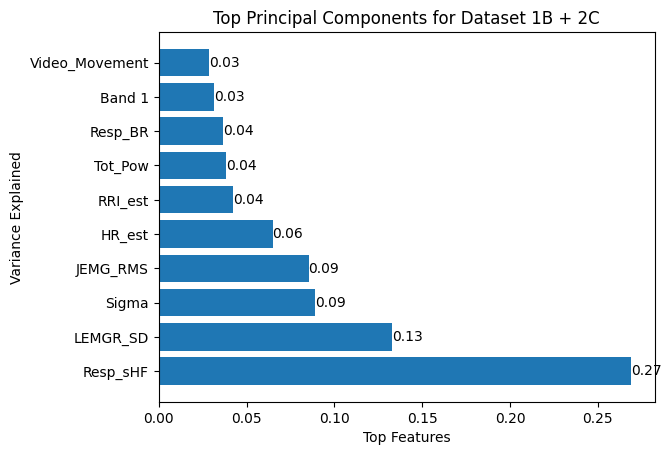

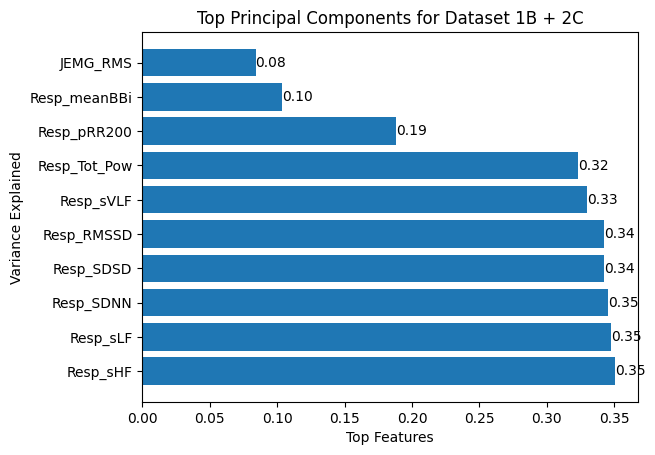





N2    4721
N3    2003
N1    1714
R     1459
Name: SleepStage, dtype: int64


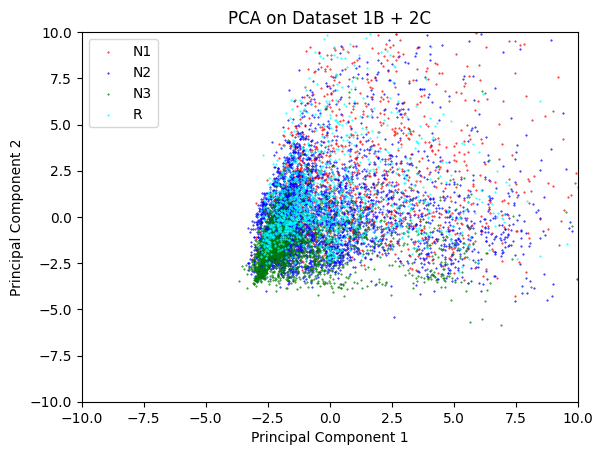

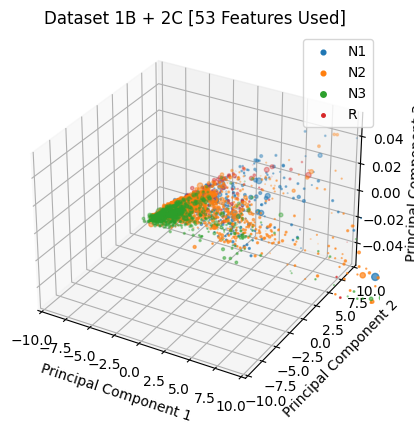

In [11]:
table4=pd.concat([ds1,ds2])
plot(table4, "1B + 2C", clarr=[0,1],clsort="label")
plot(table4, "1B + 2C", clarr=[0,1,2,3])

 Top TOP Features Index(['Resp_sHF', 'Resp_sLF', 'Resp_SDNN', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'Resp_meanBBi', 'JEMG_RMS'],
      dtype='object')




[[0.27101113690239853 0.13159145094698063 0.08943397774610597
  0.08696303575965175 0.06444905682673989 0.0435600120564559
  0.03689777258082675 0.034638275251195796 0.03154129788761296
  0.027685106425152393]
 ['Resp_sHF' 'LEMGL_RMS' 'Sigma' 'JEMG_RMS' 'HR_est' 'Resp_meanBBi' 'S'
  'Resp_BR' 'Band 1' 'Video_Movement']]


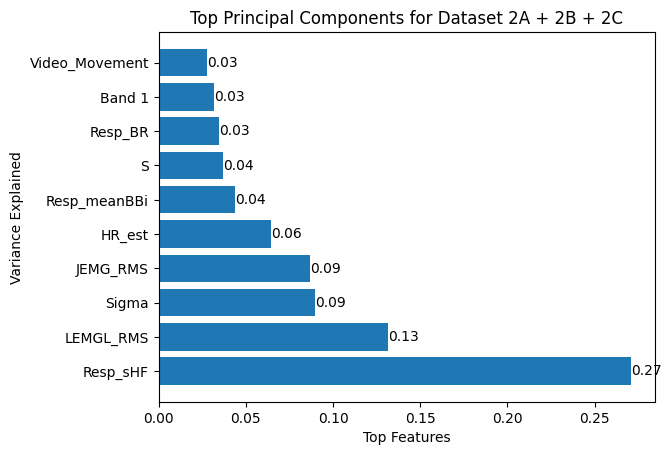

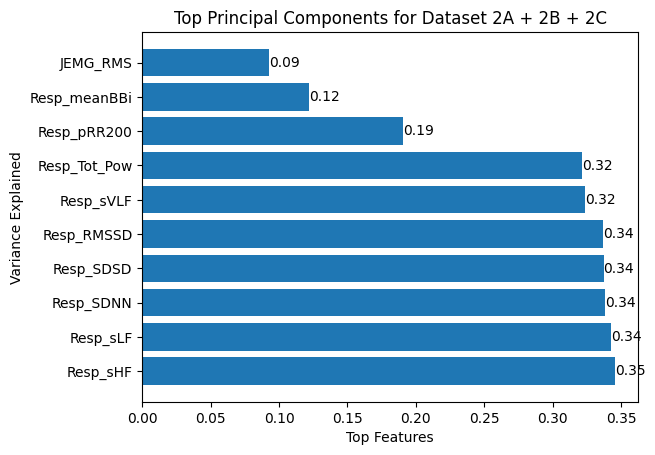





N2    7140
N3    2922
N1    2767
R     2133
Name: SleepStage, dtype: int64


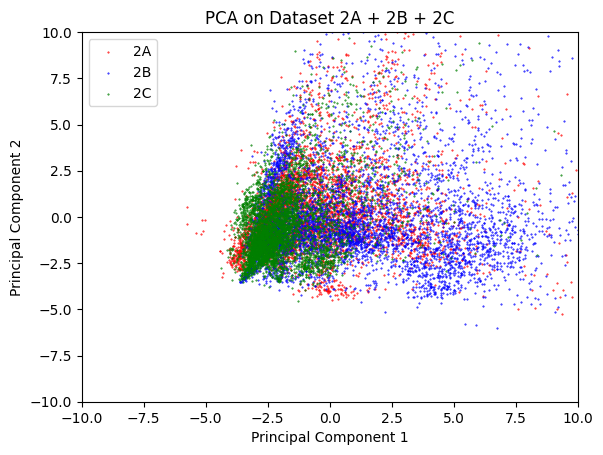

ValueError: need at least one array to concatenate

<Figure size 640x480 with 1 Axes>

 Top TOP Features Index(['Resp_sHF', 'Resp_sLF', 'Resp_SDNN', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'Resp_meanBBi', 'JEMG_RMS'],
      dtype='object')




[[0.27101113690239853 0.13159145094698063 0.08943397774610597
  0.08696303575965175 0.06444905682673989 0.0435600120564559
  0.03689777258082675 0.034638275251195796 0.03154129788761296
  0.027685106425152393]
 ['Resp_sHF' 'LEMGL_RMS' 'Sigma' 'JEMG_RMS' 'HR_est' 'Resp_meanBBi' 'S'
  'Resp_BR' 'Band 1' 'Video_Movement']]


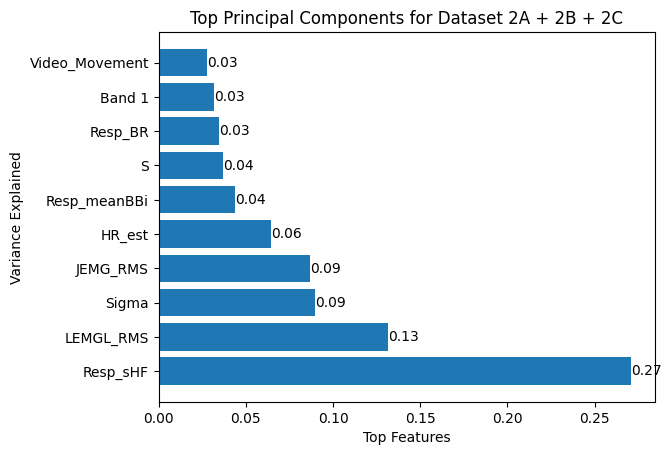

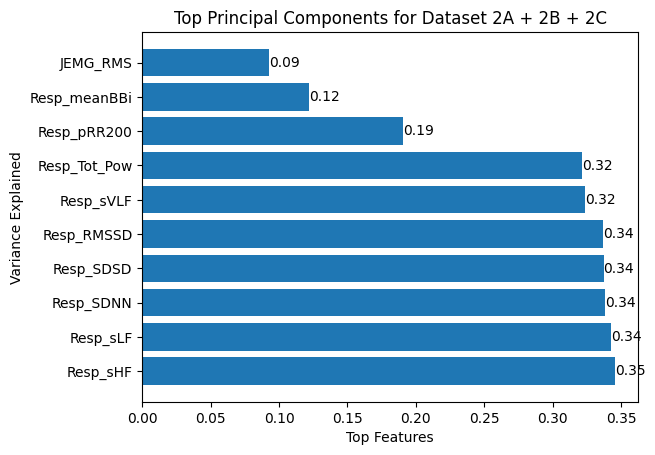





N2    7140
N3    2922
N1    2767
R     2133
Name: SleepStage, dtype: int64


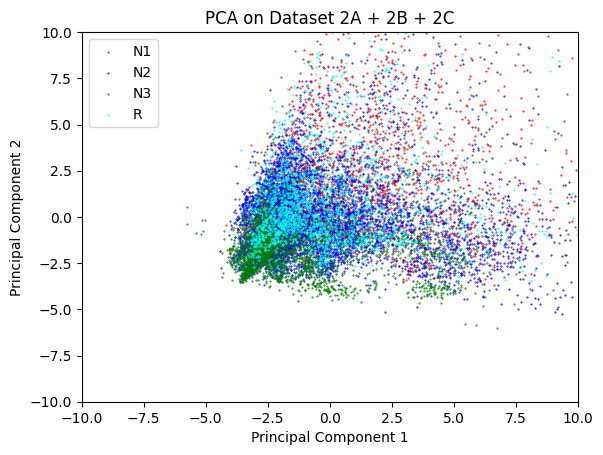

ValueError: need at least one array to concatenate

<Figure size 640x480 with 1 Axes>

In [12]:
plot(table2, "2A + 2B + 2C", clarr=[0,1,2],clsort="label")
plot(table2, "2A + 2B + 2C", clarr=[0,1,2,3])

 Top TOP Features Index(['Resp_sHF', 'Resp_sLF', 'Resp_SDNN', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'Resp_meanBBi', 'JEMG_RMS'],
      dtype='object')




[[0.2687074137833546 0.13194767833851884 0.08835967156121444
  0.08710051894998301 0.0645344197958606 0.042972680775375825
  0.0373275580000337 0.03595067483188133 0.03154248348864277
  0.028221063522910195]
 ['Resp_sHF' 'LEMGR_SD' 'Sigma' 'JEMG_RMS' 'HR_est' 'Resp_meanBBi' 'S'
  'Resp_BR' 'Band 1' 'Video_Movement']]


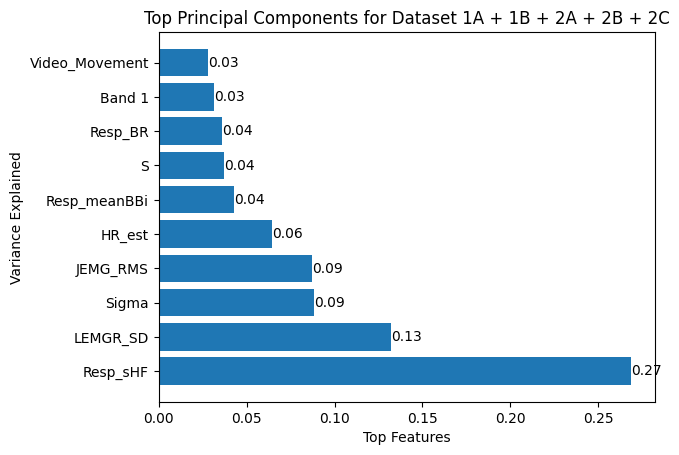

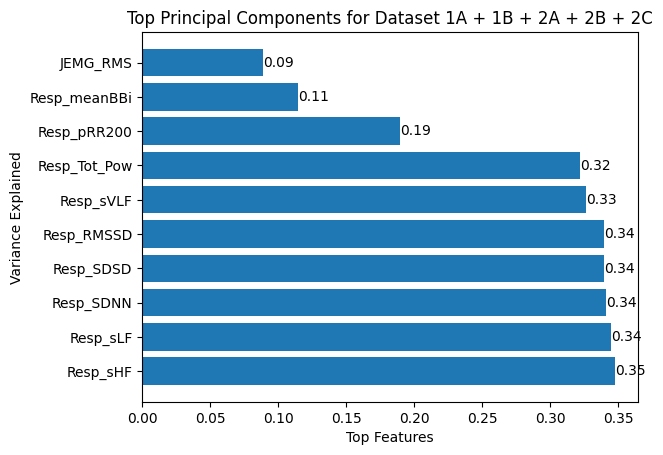





N2    11861
N3     4925
N1     4481
R      3592
Name: SleepStage, dtype: int64


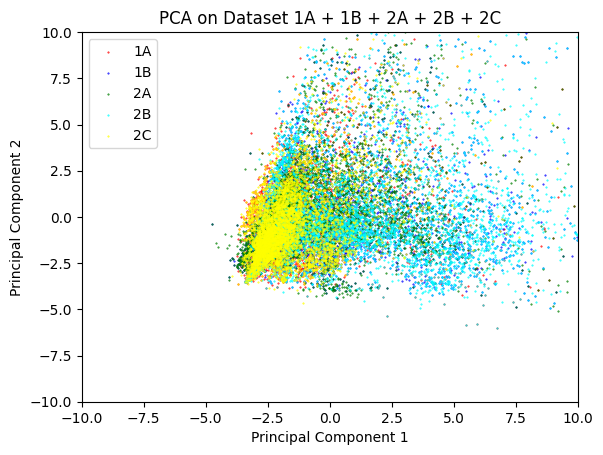

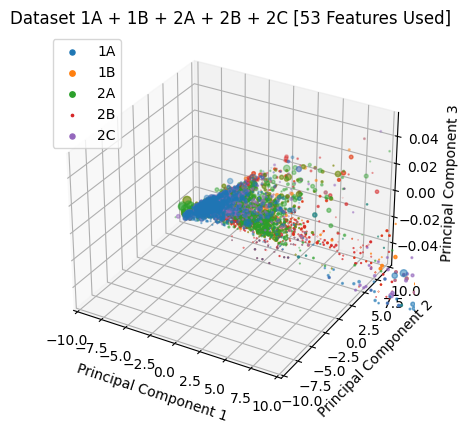

 Top TOP Features Index(['Resp_sHF', 'Resp_sLF', 'Resp_SDNN', 'Resp_SDSD', 'Resp_RMSSD',
       'Resp_sVLF', 'Resp_Tot_Pow', 'Resp_pRR200', 'Resp_meanBBi', 'JEMG_RMS'],
      dtype='object')




[[0.2687074137833546 0.13194767833851884 0.08835967156121444
  0.08710051894998301 0.0645344197958606 0.042972680775375825
  0.0373275580000337 0.03595067483188133 0.03154248348864277
  0.028221063522910195]
 ['Resp_sHF' 'LEMGR_SD' 'Sigma' 'JEMG_RMS' 'HR_est' 'Resp_meanBBi' 'S'
  'Resp_BR' 'Band 1' 'Video_Movement']]


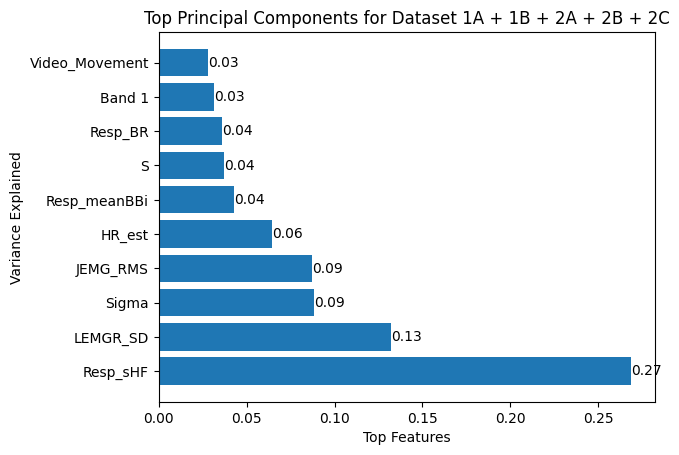

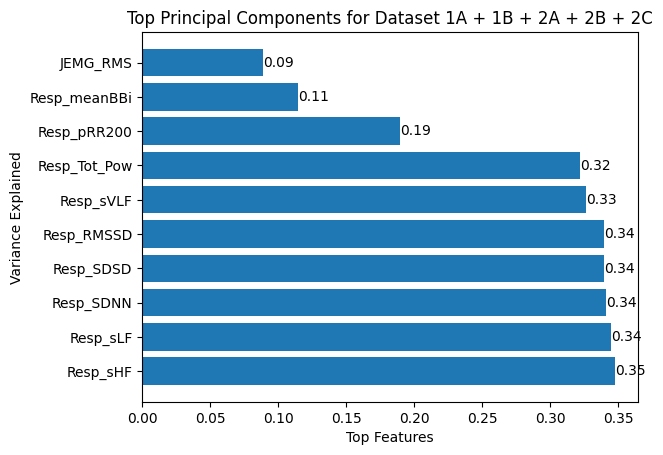





N2    11861
N3     4925
N1     4481
R      3592
Name: SleepStage, dtype: int64


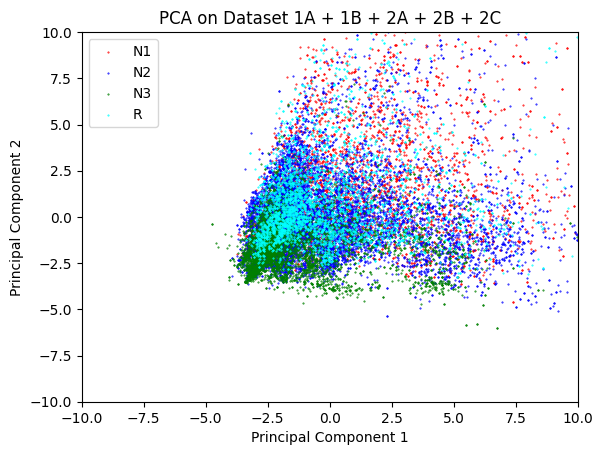

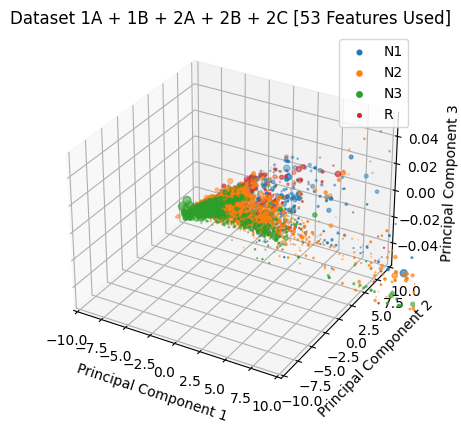

In [13]:
plot(table3, "1A + 1B + 2A + 2B + 2C", clarr=[0,1,2,3,4], clsort="label")
plot(table3, "1A + 1B + 2A + 2B + 2C", clarr=[0,1,2,3])

In [14]:
np.unique(target)

NameError: name 'target' is not defined

In [ ]:
target

In [ ]:
fig, ax = plt.subplots()
plt.scatter(components[:,1],components[:,2],0.5,target)
plt.axis([-10,10,-10,10])
plt.show()